In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import tensorflow as tf
import memory_util
import sys

%matplotlib inline

In [2]:
#####################################################################################
# <codecell> global
#####################################################################################

memory_util.vlog(1)

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

tf.logging.set_verbosity(tf.logging.ERROR)

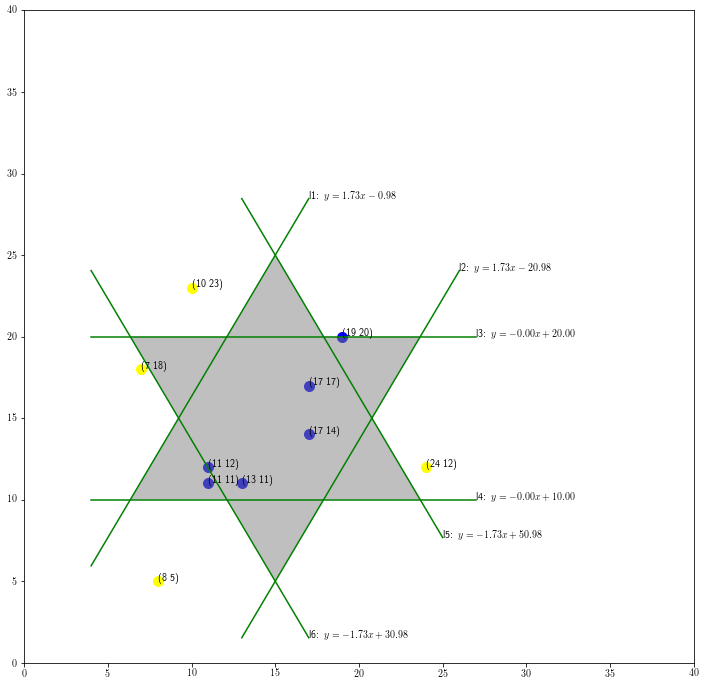

In [3]:
#####################################################################################
# <codecell> plot snowflake
#####################################################################################

# 一下代码只是为了理解神经元(op节点)操作数据的过程, 操作是手动加上的,而非机器学习得到
# 的, 本实例: 一个2D平面现行不可分, 如何做到可分, 实际上就是多条线进行划分

sess = tf.Session()

##

inputs = tf.placeholder(dtype=tf.float32, shape=(2), name='inputs')

# 外圈半径
r1 = 10
# 内圈半径
r2 = r1/2 / np.cos(30*np.pi / 180)
# 位移
m = r1 + 5

# TF打印, 添加中间OP的打印
debug_ops = []
xs = []
ys = []

angles = np.array([i*np.pi / 180 for i in range(0, 360) if i % 30 == 0])
for i, angle in enumerate(angles, 0):
    if i % 2 == 1:
        xs.append(r1 * np.cos(angle) + m)
        ys.append(r1 * np.sin(angle) + m)
    else:
        xs.append(r2 * np.cos(angle) + m)
        ys.append(r2 * np.sin(angle) + m)

xs.append(xs[0])
ys.append(ys[0])

path = Path([(x,y) for x, y in zip(xs, ys)])
patch = patches.PathPatch(path, facecolor='grey', lw=0, alpha=0.5)
plt.gca().add_patch(patch)

plt.xlim(0, 40)
plt.ylim(0, 40)

# 计算线性方程参数k,b,计算新点
def plot_linear_equation(name, i, j, x1, x2):
    k = (ys[i] - ys[j]) / (xs[i] - xs[j])
    b = ys[i] - k * xs[i]
    # print('%s: (%d, %d) k = %.2f, b = %.2f' % (name, i, j, k, b))
    xp = (x1, x2)
    yp = (k*x1+b, k*x2+b)
    plt.plot(xp, yp, color='g')
    plt.text(xp[1], yp[1], s = r' %s: $y = %.2fx %s %.2f$' % (
        name, k, '' if b < 0 else '+', b))
    w = tf.constant((k, -1), dtype=tf.float32)
    b = tf.constant((b, 0), dtype=tf.float32)
    debug_ops.append(tf.print('%s: ' % name, w * inputs + b,
        output_stream=sys.stderr))
    return tf.cast(tf.nn.sigmoid(
        tf.math.reduce_sum(w * inputs + b)) < 0.5, tf.int32)

def check_result(d, i, x, y):
    data = sess.run(d, feed_dict={inputs:[x, y]})
    res = 0
    if ((data[0] == 0 and data[1] == 1 and data[2] == 0 and 
        (data[3] == 1 and data[4] == 0 and data[5] == 1)) or
        (data[0] == 0 and data[2] == 1 and data[4] == 0) or
        (data[1] == 1 and data[2] == 0 and data[4] == 1) or
        (data[1] == 0 and data[3] == 1 and data[4] == 0) or
        (data[1] == 1 and data[3] == 0 and data[5] == 1) or
        (data[0] == 0 and data[3] == 1 and data[5] == 0) or
        (data[0] == 1 and data[2] == 0 and data[5] == 1)): # noqa:E129
        res = 1

    if res == 0:
        plt.scatter(x, y, s=100, color='yellow', marker='o')
    else:
        plt.scatter(x, y, s=100, color='blue', marker='o')
    plt.text(x, y, s=r'(%d %d)' % (x, y))

l1 = plot_linear_equation('l1', 3, 7, 4, 17)
l2 = plot_linear_equation('l2', 1, 9, 13, 26)
l3 = plot_linear_equation('l3', 5, 1, 4, 27)
l4 = plot_linear_equation('l4', 7, 11, 4, 27)
l5 = plot_linear_equation('l5', 3, 11, 13, 25)
l6 = plot_linear_equation('l6', 5, 9, 4, 17)

with tf.control_dependencies(debug_ops):
    data = tf.stack([l1, l2, l3, l4, l5, l6])
    with memory_util.capture_stderr() as stderr:
        for i in range(10):
            points = np.random.randint(5, 26, 2, dtype=np.int32)
            check_result(data, i, points[0], points[1])
    # print(stderr.getvalue())

##

sess.close() # noqa

# 蓝色点在雪花区域内, 黄色点雪花区域外, 本示例只是为了娱乐, 没有参考价值.